In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from grab_data import fetch_data
from pathlib import Path
import scipy.optimize as sci_plt

#Set your desired stock symbol, date range and risk-free rate
stock_symbol = ["AAPL","MSFT", "AMZN"]
number_of_symbols = len(stock_symbol)
start_date = "2023-03-15"
end_date = "2025-08-22"

file_path = Path("/Users/seanliew/Documents/Portfolio Optimization/data/stock_data_test.csv")
#Fetch stock data from imported function
stock_data = fetch_data(stock_symbol,start_date,end_date)
print(stock_data)

[*********************100%***********************]  3 of 3 completed

Price        Adj Close                               Close              \
Ticker            AAPL        AMZN        MSFT        AAPL        AMZN   
Date                                                                     
2023-03-15  151.092712   96.199997  260.377563  152.990005   96.199997   
2023-03-16  153.917236  100.040001  270.932343  155.850006  100.040001   
2023-03-17  153.077789   98.949997  274.100739  155.000000   98.949997   
2023-03-20  155.448013   97.709999  267.038055  157.399994   97.709999   
2023-03-21  157.304672  100.610001  268.558441  159.279999  100.610001   
...                ...         ...         ...         ...         ...   
2025-08-15  231.589996  231.029999  519.316284  231.589996  231.029999   
2025-08-18  230.889999  231.490005  516.251282  230.889999  231.490005   
2025-08-19  230.559998  228.009995  508.933350  230.559998  228.009995   
2025-08-20  226.009995  223.809998  504.890015  226.009995  223.809998   
2025-08-21  224.899994  221.949997  50

In [18]:
from grab_data import collect_adjclose
# Since we only need adjusted closing values

portfolio_symbols = ["AAPL", "MSFT", "AMZN"]
start_date = "2023-03-15"
end_date = "2025-08-22"

results = collect_adjclose(portfolio_symbols, start_date, end_date)
print(results)
#Store adj closing values in csv file
results.to_csv("/Users/seanliew/Documents/Portfolio Optimization/data/stock_data_test.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Adj Close                        
Ticker            AAPL        MSFT        AMZN
Date                                          
2023-03-15  151.092712  260.377563   96.199997
2023-03-16  153.917236  270.932343  100.040001
2023-03-17  153.077789  274.100739   98.949997
2023-03-20  155.448013  267.038055   97.709999
2023-03-21  157.304672  268.558441  100.610001
...                ...         ...         ...
2025-08-15  231.589996  519.316284  231.029999
2025-08-18  230.889999  516.251282  231.490005
2025-08-19  230.559998  508.933350  228.009995
2025-08-20  226.009995  504.890015  223.809998
2025-08-21  224.899994  504.239990  221.949997

[612 rows x 3 columns]


# Preprocess the Data

In [19]:
# Calculate the log return
results.dropna(inplace=True)
returns= results.pct_change()
returns.dropna(inplace=True)
log_return = np.log(1 + returns)

# Generate some random weights
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the rebalanced weights, ensuring it equals to 1
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns (Annualized, 252 working days a year)
exp_ret =np.sum((log_return.mean()*rebalance_weights)*252)

# Expected Volatility (Annualized)
exp_vol = np.sqrt(
    np.dot(rebalance_weights.T,
           np.dot(log_return.cov() * 252, rebalance_weights))
)

# Calculate the Sharpe Ratio
sharpe_ratio = (exp_ret - .01)/exp_vol


# Placing the weights into a data frame for visual purposes
weights_df = pd.DataFrame(data={
    'random_weights': random_weights,
    'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Doing the same with other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index = [0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)






PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.606215           0.515525
1        0.346786           0.294907
2        0.222916           0.189568
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.230326                       0.220312   

   Portfolio Sharpe Ratio  
0                1.000062  
--------------------------------------------------------------------------------


In [20]:
# Define the number of times we want to run the simulation
num_of_portfolios = 3000

# Weight Array of Numpy Zeros
all_weights = np.zeros((num_of_portfolios , number_of_symbols))

# Returns Array of Numpy Zeros
ret_arr = np.zeros(num_of_portfolios)

# Volatility Array of Numpy Zeros
vol_arr = np.zeros(num_of_portfolios)

# Sharpe Array of Numpy Zeros
sharpe_arr = np.zeros(num_of_portfolios)

# Starting the simulation
for ind in range(num_of_portfolios):

    # Calculate the weights
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights/np.sum(weights)

    # Add the weights to Weights Array
    all_weights[ind, : ] = weights

    # Calculate the log returns
    ret_arr[ind] = np.sum((log_return.mean()*weights)*252)

    # Calculate the volatility and adding to the array
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T,
            np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio
    sharpe_arr[ind] = (ret_arr[ind] - .01)/ vol_arr[ind]

# Combine all together
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a Dataframe from the master array
simulation_df = pd.DataFrame(data = simulations_data).T

# Giving columns names
simulation_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]
# Make sure the data types are correct
simulation_df = simulation_df.infer_objects()

# Print out the Results
print('')
print('='*80)
print('SIMULATION RESULTS:')
print('-'*80)
print(simulation_df)
print('-'*80)


SIMULATION RESULTS:
--------------------------------------------------------------------------------
       Returns  Volatility  Sharpe Ratio  \
0     0.269891    0.236756      1.097716   
1     0.263792    0.216743      1.170935   
2     0.244467    0.227234      1.031830   
3     0.289051    0.244225      1.142596   
4     0.260642    0.224797      1.114970   
...        ...         ...           ...   
2995  0.194058    0.236656      0.777744   
2996  0.223218    0.220457      0.967161   
2997  0.257622    0.221340      1.118739   
2998  0.291627    0.264329      1.065442   
2999  0.297550    0.246861      1.164825   

                                      Portfolio Weights  
0     [0.3365753197454066, 0.19495759877755553, 0.46...  
1     [0.21091761626191552, 0.5939069379155572, 0.19...  
2     [0.47179895712846487, 0.20854187551259612, 0.3...  
3     [0.21195004098415485, 0.24157240948040692, 0.5...  
4     [0.3392826154988199, 0.3162383243352971, 0.344...  
...                  

In [21]:
# Grab the Maximum Sharpe Ratio
max_sharpe_ratio = simulation_df.loc[simulation_df['Sharpe Ratio'].idxmax()]

# Grab the Minimum Volatility
min_volatility = simulation_df.loc[simulation_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                       0.297407
Volatility                                                    0.234412
Sharpe Ratio                                                  1.226076
Portfolio Weights    [0.008071117973255285, 0.6361525404217747, 0.3...
Name: 1129, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                       0.233845
Volatility                                                    0.211544
Sharpe Ratio                                                   1.05815
Portfolio Weights    [0.37341832326334906, 0.6018526190301787, 0.02...
Name: 1621, dtype: object
--------------------------------------------------------------------------------


# Plotting

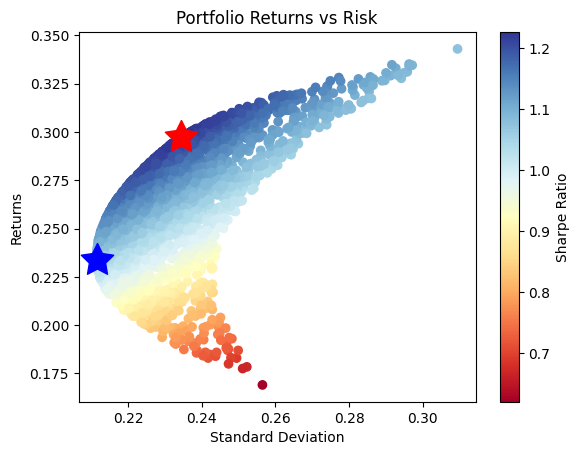

In [22]:
%matplotlib inline

# Plotting data on scatter plot
plt.scatter(
    y = simulation_df['Returns'],
    x = simulation_df['Volatility'],
    c = simulation_df['Sharpe Ratio'],
    cmap = 'RdYlBu'
)

# Titles and Axis Labels of plots 
plt.title('Portfolio Returns vs Risk')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the max Sharpe Ratio using a red star
plt.scatter(
    max_sharpe_ratio.iloc[1],
    max_sharpe_ratio.iloc[0],
    marker = (5,1,0),
    color = 'r',
    s = 600
)

# Plot the min Volatility using a red star
plt.scatter(
    min_volatility.iloc[1],
    min_volatility.iloc[0],
    marker = (5,1,0),
    color = 'b',
    s = 600
)

plt.show()

# Defining Functions for Scipy Optimization

In [23]:
def get_metrics(weights: list) -> np.array:

    # convert the weights to a numpy array
    weights = np.array(weights)

    # calculate annualized returns
    ret = np.sum(log_return.mean()*weights) * 252

    # calculate volatility
    vol = np.sqrt(
        np.dot(weights.T,
            np.dot(log_return.cov() * 252, weights))
    )

    # calculate the sharpe ratio
    sr = (ret - .01) / vol
    
    return np.array([ret,vol,sr])

def grab_negative_sharp(weights:list) -> np.array:
    return -get_metrics(weights)[2]

def grab_volatility(weights:list) -> np.array:
    return get_metrics(weights)[1]

def check_sum(weights:list) -> float:
    return np.sum(weights)-1

In [ ]:
# Define the bounds for optimization
bounds = tuple((0,1) for symbol in range(number_of_symbols))

# Definte the constraints to make sure weights do not exceed 100%
constraints = ({'type' : 'eq' , 'fun': check_sum})

# Define initial guesses
init_guess = number_of_symbols * [1/ number_of_symbols]

# Perform the optimization process
optimized_sharpe = sci_plt.minimize(
    grab_negative_sharp, # what need to minimize
    init_guess, # these are the initial weights
    method = 'SLSQP',
    bounds = bounds,
    constraints = constraints
)

# Print results
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO :')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO :
--------------------------------------------------------------------------------
     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -1.2268885800089877
           x: [ 9.189e-18  6.384e-01  3.616e-01]
         nit: 5
         jac: [ 5.284e-02 -4.256e-02 -4.238e-02]
        nfev: 20
        njev: 5
 multipliers: [-4.250e-02]
--------------------------------------------------------------------------------


In [27]:
# Grab the metrics
optimized_metrics = get_metrics(weights = optimized_sharpe.x)

# Print optimized weights
print('')
print('='*80)
print('OPTIMIZED WEIGHTS :')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)

# Print Optimized Metrics
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS :
--------------------------------------------------------------------------------
[9.18909382e-18 6.38354183e-01 3.61645817e-01]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.29870658 0.23531606 1.22688858]
--------------------------------------------------------------------------------
